In [13]:
import os
import psycopg
import pymongo
import statistics
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from tqdm import tqdm
import binascii
import polars as pl
import numpy as np

from collections import Counter
from matplotlib import pyplot as plt

from tools.utils.mongodb_utils import get_mongodb_collections, get_one_document_from_mongodb_by_key
from tools.utils.misc import apply_sloth, create_token_set

Here there are some random tests that are better implemented in scripts or in other contexts

In [6]:
import pymongo

mongoclient = pymongo.MongoClient(directConnection=True)

collection = eval('mongoclient.optitab.gittables')
print(collection)


Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, directconnection=True), 'optitab'), 'gittables')


In [8]:
'optitab' in mongoclient.list_database_names()

True

In [ ]:
mongoclient.close()

## How are divided the query, w.r.t. their set size (set semantic)?

In [28]:
thresholds = [1, 50, 100, 250, 500, 1000, 10000]
bins=[50, 100, 250, 500, 1000, 10000]

In [29]:
extrres = pd.read_csv('/data4/nanni/tesi-magistrale/data/tests/a_test/wikipedia/results/extracted/final_results_k10_q50K.csv').dropna()
extrres = extrres[['query_id', 'query_size']].drop_duplicates()
tot = extrres.shape[0]
r = []

for i in range(len(thresholds) - 1):    
    s = extrres[(extrres['query_size'] >= thresholds[i]) & (extrres['query_size'] < thresholds[i + 1])].shape[0]
    print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")
    r.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 3)])

1<=X<50:	38512	77.02554051081022
50<=X<100:	6897	13.79427588551771
100<=X<250:	3332	6.664133282665653
250<=X<500:	885	1.7700354007080141
500<=X<1000:	256	0.5120102402048041
1000<=X<10000:	117	0.23400468009360187


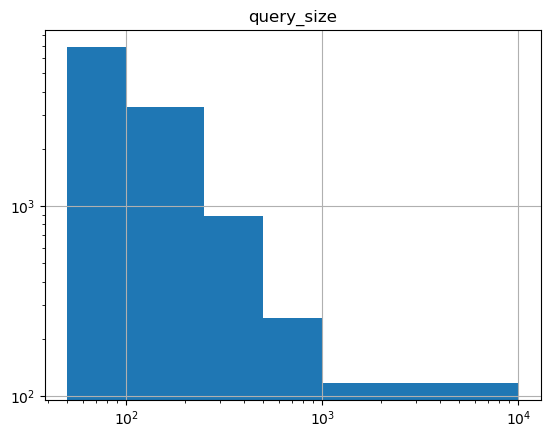

In [30]:
extrres.hist('query_size', bins=bins)
plt.xscale('log')
plt.yscale('log')

In [31]:
extrres = pd.read_csv('/data4/nanni/tesi-magistrale/data/tests/a_test/gittables/results/extracted/final_results_k10_q50K.csv').dropna()
extrres = extrres[['query_id', 'query_size']].drop_duplicates()
tot = extrres.shape[0]
r1 = []

for i in range(len(thresholds) - 1):    
    s = extrres[(extrres['query_size'] >= thresholds[i]) & (extrres['query_size'] < thresholds[i + 1])].shape[0]
    print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")
    r1.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 3)])

1<=X<50:	10499	20.999259955597335
50<=X<100:	11368	22.73736424185451
100<=X<250:	20974	41.95051703102186
250<=X<500:	3455	6.910414624877492
500<=X<1000:	2559	5.118307098425905
1000<=X<10000:	1139	2.278136688201292


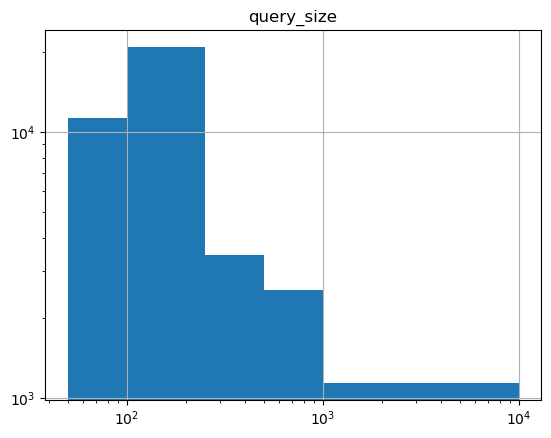

In [32]:
extrres.hist('query_size', bins=bins)
plt.xscale('log')
plt.yscale('log')

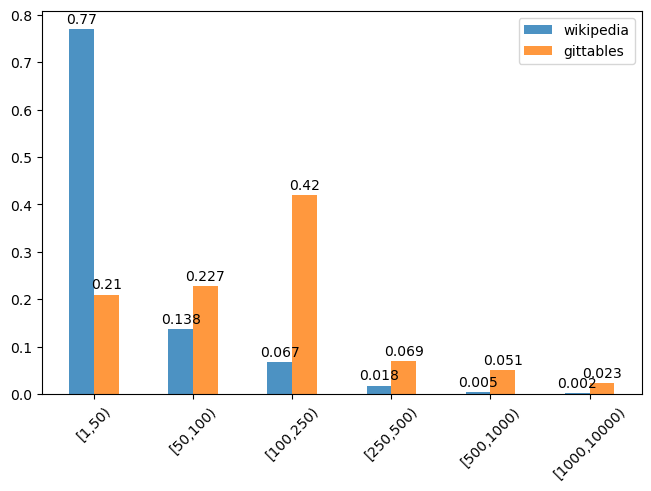

In [33]:
width = 0.25  # the width of the bars
multiplier = 0

x = np.arange(len(r)) # np.array([x[0] for x in data])
fig, ax = plt.subplots(layout='constrained')

for data, label in zip([r, r1], ['wikipedia', 'gittables']):
    offset = width * multiplier
    rects = ax.bar(x + offset, [y[1] for y in data], align='edge', alpha=0.8, label=label, width=width)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.legend()
ax.set_xticks(x + width, [y[0] for y in data])
ax.tick_params(axis='x', rotation=45)

## How many query doesn't have exactly K returned tables for each algorithm/method?

In [3]:
results = pl.read_csv('/data4/nanni/tesi-magistrale/data/tests/a_test/wikipedia/results/extracted/final_results_k10_q50K.csv')

In [13]:
bad_groups = []
for query_id, q_group in tqdm(results.to_pandas().groupby('query_id'), total=results.select('query_id').unique().shape[0]):
    for (alg, mode), data in q_group.groupby(['algorithm', 'mode']):
        if data.shape[0] < 10:
            bad_groups.append(query_id)
            break

100%|██████████| 50000/50000 [00:37<00:00, 1331.12it/s]


In [15]:
len(bad_groups) * 100 / 50000

5.8

In [11]:
bad_groups = []
qgroups = results.select('query_id', 'algorithm', 'mode').group_by('query_id')
for query_id, q_group in tqdm(qgroups, total=results.select('query_id').shape[0]):
    for (alg, mode), data in q_group.group_by('algorithm', 'mode'):
        if data.shape[0] < 10:
            bad_groups.append(query_id)
            break

  0%|          | 69/2958824 [00:04<47:53:34, 17.16it/s]


KeyboardInterrupt: 

In [5]:
q_group

query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,sloth_time(s)
i64,i64,str,str,i64,i64,i64,i64,i64,f64
373974,373975,"""josie""","""bag""",16,6,44,47,10,0.0
373974,373981,"""josie""","""bag""",16,8,44,29,5,0.0
373974,74940,"""josie""","""bag""",16,9,44,49,8,0.0
373974,340187,"""josie""","""bag""",15,10,44,71,7,0.0
373974,536889,"""josie""","""bag""",15,10,44,49,8,0.0
…,…,…,…,…,…,…,…,…,…
373974,43515,"""embedding""","""fasttextdist""",0,0,44,5,0,0.0
373974,43521,"""embedding""","""fasttextdist""",0,0,44,5,0,0.0
373974,43524,"""embedding""","""fasttextdist""",0,0,44,5,0,0.0
